<a href="https://colab.research.google.com/github/JASONZ777/senti_analysis_Prompt_BERT_LoRA/blob/main/lora_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Method 3： LoRA-tuning

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/MyDrive/sentiment-analysis')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.data import Dataset

class upload_dataset(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)

    def load_data(self, data_file):
        Data = {}
        with open(data_file, 'rt', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                items = line.strip().split('\t')
                assert len(items) == 2
                Data[idx] = {
                    'comment': items[0],
                    'label': int(items[1]),
                }
        return Data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# testing
train_data = upload_dataset('chnsenticorp/train/part.0')
valid_data = upload_dataset('chnsenticorp/dev/part.0')
test_data = upload_dataset('chnsenticorp/test/part.0')
print(f'train set size: {len(train_data)}')
print(f'valid set size: {len(valid_data)}')
print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 9600
valid set size: 1200
test set size: 1200
{'comment': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'label': 1}


In [ ]:
def map_label(tokenizer):
    return {
        '1': {'token': '好', 'id': tokenizer.convert_tokens_to_ids("好")},
        '0': {'token': '差', 'id': tokenizer.convert_tokens_to_ids("差")}
    }

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
# checkpoint = 'bert-base-chinese'
checkpoint = 'hfl/chinese-roberta-wwm-ext'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# find the id of the label defined in tokenizer
label = map_label(tokenizer)
pos_id, neg_id = label['1']['id'], label['0']['id']
# Dataloader, in NLP we usually use collate_fn to do the padding to make sure samples have the same sequence length
def collate(batch_samples): # operate on each batch
    batch_sentence = []
    batch_label = []
    batch_mask_id = []
    max_length = 0
    for sample in batch_samples:
        batch_sentence.append(sample['comment'])
        encoding = tokenizer(sample['comment'], truncation=True)
        max_length = max(max_length, len(encoding.tokens())) # dynamic padding to the longest
        batch_label.append(sample['label'])
    batch_inputs = tokenizer(batch_sentence, max_length=496, padding=True, truncation=True, return_tensors="pt")
    label_id = [neg_id, pos_id]
    return {
        'batch_inputs':batch_inputs,
        'label_id': label_id,
        'labels': batch_label

    }


In [ ]:
!pip install -q peft
!pip install -q evaluate
!pip install bitsandbytes
!pip install -q accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

## Lora using PEFT

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model, PromptTuningConfig, PromptTuningInit
from transformers import BertForSequenceClassification, BitsAndBytesConfig
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=1, lora_alpha=1, lora_dropout=0.1
)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

prompt_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    prompt_tuning_init=PromptTuningInit.RANDOM,
    num_virtual_tokens=16,
    tokenizer_name_or_path=checkpoint
)
base_model = BertForSequenceClassification.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    use_cache=False,
)

model = get_peft_model(base_model, lora_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Lora from scratch

In [ ]:
from functools import partial

class Loralayer(nn.Module):
  def __init__(self,in_dim,out_dim,rank,alpha):
    super().__init__()
    std = 1/torch.sqrt(torch.tensor(rank).float())
    self.A = nn.Parameter(torch.randn(in_dim,rank)*std)
    self.B = nn.Parameter(torch.zeros(rank,out_dim))
    self.alpha = alpha/rank
  def forward(self,x):
    x = self.alpha*(x @ self.A @ self.B)
    return x

class Linearwithlora(nn.Module):
  def __init__(self,linear,rank,alpha):
    super().__init__()
    self.linear = linear
    self.lora = Loralayer(linear.in_features,linear.out_features,rank,alpha)
  def forward(self,x):
    x = self.linear(x)+self.lora(x)
    return x

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = BertForSequenceClassification.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    use_cache=False,
)

for param in base_model.parameters():
  param.requires_grad = False

# parameter setting
r = 1
alpha = 1
dropout = 0.1
lora = partial(Linearwithlora, rank=r, alpha=alpha)
for layer in base_model.bert.encoder.layer:
  layer.attention.self.query = lora(layer.attention.self.query)
  layer.attention.self.key = lora(layer.attention.self.key)
  layer.attention.self.value = lora(layer.attention.self.value)

base_model.classifier = lora(base_model.classifier)
print(base_model)






`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linearwithlora(
                (linear): Linear4bit(in_features=768, out_features=768, bias=True)
                (lora): Loralayer()
              )
              (key): Linearwithlora(
                (linear): Linear4bit(in_features=768, out_features=768, bias=True)
                (lora): Loralayer()
              )
              (value): Linearwithlora(
                (linear): Linear4bit(in_features=768, out_features=768, bias=Tr

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 38402 || all params: 59545348 || trainable%: 0.06449202379336166


In [ ]:
from transformers import AdamW
from tqdm import tqdm
# Hyper-parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# put data to GPU
def to_device(batch_data):
    new_batch_data = {}
    for k, v in batch_data.items():
        if k == 'batch_inputs':
            new_batch_data[k] = {
                k_: v_.to(device) for k_, v_ in v.items()
            }
        elif k == 'label_id':
            new_batch_data[k] = v
        else:
            new_batch_data[k] = torch.tensor(v).to(device)
    return new_batch_data

optimizer = AdamW(model.parameters(), lr=2e-4)
loss_fun = torch.nn.CrossEntropyLoss()
num_epoch = 10
batch_size = 16

# encapsulate into the dataloader as input
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=collate)

# logs
loss_hists = {'train':[],'val': []}
acc_hists = {'train':[],'val': []}

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:  50%|█████     | 300/600 [04:25<04:25,  1.13it/s]


Epoch 1/10, Training Loss: 0.4836, Training accuracy: 0.7508
Epoch 1/10, Validation loss: 0.2952, Validation accuracy: 0.8925


Epoch 2/10:  50%|█████     | 300/600 [04:11<04:11,  1.19it/s]


Epoch 2/10, Training Loss: 0.2809, Training accuracy: 0.8971
Epoch 2/10, Validation loss: 0.2593, Validation accuracy: 0.9017


Epoch 3/10:  50%|█████     | 300/600 [04:04<04:04,  1.23it/s]


Epoch 3/10, Training Loss: 0.2410, Training accuracy: 0.9102
Epoch 3/10, Validation loss: 0.2440, Validation accuracy: 0.9142


Epoch 4/10:  50%|█████     | 300/600 [04:10<04:10,  1.20it/s]


Epoch 4/10, Training Loss: 0.2278, Training accuracy: 0.9196
Epoch 4/10, Validation loss: 0.2284, Validation accuracy: 0.9183


Epoch 5/10:  50%|█████     | 300/600 [04:09<04:09,  1.20it/s]


Epoch 5/10, Training Loss: 0.2124, Training accuracy: 0.9246
Epoch 5/10, Validation loss: 0.2196, Validation accuracy: 0.9233


Epoch 6/10:  50%|█████     | 300/600 [04:13<04:13,  1.19it/s]


Epoch 6/10, Training Loss: 0.2102, Training accuracy: 0.9187
Epoch 6/10, Validation loss: 0.2089, Validation accuracy: 0.9242


Epoch 7/10:  50%|█████     | 300/600 [03:56<03:56,  1.27it/s]


Epoch 7/10, Training Loss: 0.2037, Training accuracy: 0.9235
Epoch 7/10, Validation loss: 0.2084, Validation accuracy: 0.9275


Epoch 8/10:  50%|█████     | 300/600 [04:05<04:05,  1.22it/s]


Epoch 8/10, Training Loss: 0.1881, Training accuracy: 0.9290
Epoch 8/10, Validation loss: 0.1967, Validation accuracy: 0.9342


Epoch 9/10:  50%|█████     | 300/600 [04:08<04:08,  1.21it/s]


Epoch 9/10, Training Loss: 0.1730, Training accuracy: 0.9402
Epoch 9/10, Validation loss: 0.2003, Validation accuracy: 0.9342


Epoch 10/10:  50%|█████     | 300/600 [04:08<04:08,  1.21it/s]


Epoch 10/10, Training Loss: 0.1759, Training accuracy: 0.9358
Epoch 10/10, Validation loss: 0.1893, Validation accuracy: 0.9367


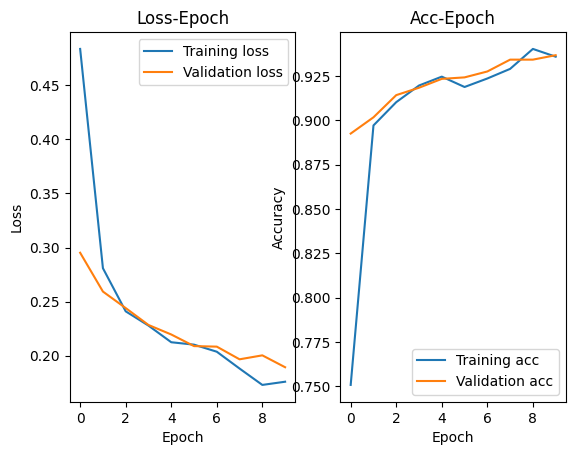

In [ ]:
import matplotlib.pyplot as plt
for epoch in range(num_epoch):
    train_loss = 0
    i = 1
    correct_num = 0
    num_batch = 0
    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}"):
      if num_batch < 300:
        model.train() # training mode
        batch_data = to_device(batch_data)
        output = model(**batch_data['batch_inputs'])
        output = output.logits
        loss = loss_fun(output, batch_data['labels'])
        loss.backward()
        train_loss+=loss.item()

        optimizer.step()
        optimizer.zero_grad()# set gradient to 0 when batch is updated


        # if i % 10 == 0: # record every 10 training batches
        #     output = output.argmax(dim=1)
        #     acc = (output == batch_data['labels']).sum().item()/ len(batch_data['labels'])
        #     print(f'Training stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

        # if i % 30 == 0: # validate every 30 batches
        #     model.eval()
        #     batch_val = next(iter(valid_loader))
        #     with torch.no_grad():
        #         batch_val = to_device(batch_val)
        #         output = model(**batch_val)
        #     val_loss = loss_fun(output, torch.tensor(batch_val['labels']))
        #     output = output.argmax(dim=1)
        #     acc = (output == torch.tensor(batch_val['labels'])).sum().item()/ len(batch_val['labels'])
        #     print(f'Validation stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

        # i+=1
        num_batch+=1
        output = output.argmax(dim=1)
        correct_num += (output == batch_data['labels']).sum().item()
      else:
        break

    acc = correct_num/(num_batch*batch_size)
    average_loss = train_loss/num_batch
    loss_hists['train'].append(average_loss)
    acc_hists['train'].append(acc)
    print(f"Epoch {epoch + 1}/{num_epoch}, Training Loss: {average_loss:.4f}, Training accuracy: {acc:.4f}")

    # validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct_num = 0
        for i, batch_data in enumerate(valid_loader):
            batch_data = to_device(batch_data)
            output = model(**batch_data['batch_inputs'])
            output = output.logits
            loss = loss_fun(output, batch_data['labels'])
            output = output.argmax(dim=1)

            correct_num += (output == batch_data['labels']).sum().item()
            val_loss+=loss

        acc = correct_num/ (len(valid_loader)*batch_size)
        average_val_loss = val_loss/len(valid_loader)

        loss_hists['val'].append(average_val_loss)
        acc_hists['val'].append(acc)
        print(f'Epoch {epoch + 1}/{num_epoch}, Validation loss: {average_val_loss:.4f}, Validation accuracy: {acc:.4f}')


# draw the loss figures
fig, ax = plt.subplots(1,2)
ax[0].plot(torch.tensor(loss_hists['train']).cpu().detach().numpy()) # can only matplotlib to plot numpy on CPU
ax[0].plot(torch.tensor(loss_hists['val']).cpu().detach().numpy())
ax[0].set_title('Loss-Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training loss', 'Validation loss'])

ax[1].plot(torch.tensor(acc_hists['train']).cpu().detach().numpy())
ax[1].plot(torch.tensor(acc_hists['val']).cpu().detach().numpy())
ax[1].set_title('Acc-Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training acc', 'Validation acc'])
plt.show()